## This laboratory will be conducted over two sessions
## You are expected to finish the software and test the code in simulation between the sessions! ##

# Manipulating objects

For this laboratory, we will use two robots distant from each other of 25cm as depicted in the figure below

<img src="./2_robot_config.png" width="500">

There is 1cm between the end-effector "shell" and the position of the frame as depicted in the figure below

<img src="./foot_close.png" width="300">

<img src="./box.jpg" width="200">

The objects to grasp are soft cubes with a 5cm side.
Three cubes are stacked on top of each other. The goal of the laboratory is to design a controller to will move the two cubes on the top away
and pick the bottom cube and lift it up by 10cm.

In [1]:
# we import useful libraries
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt

# this function returns the body Jacobian
from robot_utils import getBodyJacobianOrientedLikeSpatialFrame
from scipy import optimize

# we import the robot class
use_real_robot = False

if use_real_robot:
    from nyu_finger import NYUFingerReal    
else:
    from nyu_finger_simulator import NYUFingerSimulator


# here we define the global variables for the robot size
l0 = 0.3
l1 = 0.16
l2 = 0.16
l3 = 0.014

In [2]:
def translate(vector):
    transform = np.eye(4)
    transform[:3, 3] = vector
    return transform

def rotateX(angle):
    transform = np.eye(4)
    sin = np.sin(angle)
    cos = np.cos(angle)
    transform[1, 1] = cos
    transform[1, 2] = -sin
    transform[2, 1] = sin
    transform[2, 2] = cos
    return transform

def rotateY(angle):
    transform = np.eye(4)
    sin = np.sin(angle)
    cos = np.cos(angle)
    transform[0, 0] = cos
    transform[0, 2] = sin
    transform[2, 0] = -sin
    transform[2, 2] = cos
    return transform

def rotateZ(angle):
    transform = np.eye(4)
    sin = np.sin(angle)
    cos = np.cos(angle)
    transform[0, 0] = cos
    transform[0, 1] = -sin
    transform[1, 0] = sin
    transform[1, 1] = cos
    return transform


def forward_kinematics(theta):
    # assume theta is a vector, theta[0] = theta0, theta[1] = theta1, etc.
    # we define the lengths of the robot
    l0 = 0.3
    l1 = 0.16
    l2 = 0.16
    l3 = 0.014
    
    ###WRITE YOUR CODE HERE
    T = np.eye(4)
    
    TSH1 = translate(np.array([l0, 0, 0])) @ rotateX(theta[0]) 
    
    TSH2 = TSH1 @ translate(np.array([0, 0, l3])) @ rotateZ(theta[1]) 

    TSK = TSH2 @ translate(np.array([0, -l1, 0])) @ rotateZ(theta[2])
    
    TSF = TSK @ translate(np.array([0, -l2, 0]))
    
    ### we return the object
    return TSF

In [3]:
def linear_interpolate_trajectory(position_init, position_goal, t_init, t_goal, t):
    s = (t - t_init)/(t_goal - t_init)
    desired_position = position_init + s * (position_goal - position_init)
    desired_velocity = 1/(t_goal - t_init) * (position_goal - position_init)
    
    # we return the answer
    return desired_position, desired_velocity

def second_order_trajectory(position_init, position_goal, t_init, t_goal, t):
    T = t_goal - t_init
    s = 3/(T**2)*((t-t_init)**2) - 2/ (T**3)*(t-t_init)**3
    desired_position = position_init + s * (position_goal - position_init)
    desired_velocity = (6/(T**2)*(t-t_init) - 6/(T**3)*(t-t_init)**2) * (position_goal - position_init)
    
    # we return the answer
    return desired_position, desired_velocity

def third_order_trajectory(position_init, position_goal, t_init, t_goal, t):
    T = t_goal - t_init
    desired_position = position_init + (10/(T**3)*(t-t_init)**3 + -15/(T**4)*(t-t_init)**4 + \
                                        6/(T**5)*(t-t_init)**5)*(position_goal-position_init)
    desired_velocity = (30/(T**3)*(t-t_init)**2+-60/(T**4)*(t-t_init)**3+30/(T**5)*(t-t_init)**4)*(position_goal-position_init)
    
    # we return the answer
    return desired_position, desired_velocity

In [4]:
def fingertip_position_error(joint_angles, desired_fingertip_position):
    """
    fingertip_position_error function
    input joint_angles (as a 3D vector) and desired_fingertip_position (as a 3D vector)
    output the squared distance between the desired fingertip position and the one realized by joint_angles
    """
    p_fk = forward_kinematics(joint_angles)
    error = np.subtract(p_fk[:3, 3], desired_fingertip_position)
    return error.dot(error)


def inverse_geometry(desired_fingertip_position):
    """
    inverse geometry function
    input desired_fingertip_position (3D vector of desired position of the fingertip)
    output a vector of joint angles
    """
    res = optimize.minimize(fingertip_position_error, np.array([0.0, 0.0, 0.0]), args = (desired_fingertip_position))
    return res.x

## Questions
In this laboratory you are expected to re-use code from the previous laboratories (e.g. to plot, compute forward kinematics, etc).

1. Using an impedance controller (Lab4 - use the ``getBodyJacobianOrientedLikeSpatialFrame`` function to get the Jacobian) and one trajectory generation method seen in Lab3 write a complete controller that solves the problem: move the top two cubes away, grasp the last cube and move it up by 10cm.

2. Test your controller in simulation. Save and plot the results.
   
3. Test the controller on the real robots. Save and plot the results.

4. In the report, describe in details the controller you designed (what it does, etc) and the results you obtained.

5. (optional - bonus) Extend the controller to rearrange the cubes - putting the bottom one on top of the two others.

In [5]:
#adjusted cube positions
cube_1 = np.array([0.425, -0.185, 0])
cube_2 = np.array([0.425, -0.24, 0])
cube_3 = np.array([0.425, -0.29, 0])
drop_point = cube_1 + [0,0.09,0.082]
release = drop_point + [-0.02,-0.05,0]
release2 = drop_point + [0.02,-0.05,0]
goals = np.array([item for sublist in [[goal - [0.06, 0, 0], goal, drop_point, release] for goal in [cube_1, cube_2, cube_3]] for item in sublist])
goals[-3] += [0, 0.005, 0]
goals[-1] = cube_3 + [0,0.1,0]
goals[-2] = goals[-1]
goals2 = np.array([item for sublist in [[goal + [0.06, 0, 0], goal, drop_point, release2] for goal in [cube_1, cube_2, cube_3]] for item in sublist])
goals2[-3] += [0, 0.005, 0]
goals2[-1] = cube_3 + [0,0.1,0]
goals[-2] = goals[-1]
goals2 = np.array([goal + [-.25, 0, 0] for goal in goals2])


#goals = np.array([np.array([0.38, -0.16, 0]),cube_1, cube_1 + [0,0,0.1], cube_2, cube_2 + [0,0,0.1], cube_3, cube_3 + [0,0.1,0]])


In [6]:
# we create a robot simulation or a real robot
if use_real_robot:
    robot1 = NYUFingerReal()
    motor_number = np.array([1,2,3])
    robot1.initialize('enp5s0f1', motor_number)
    
    robot2 = NYUFingerReal()
    motor_number = np.array([1,2,3])
    robot2.initialize('eno1', motor_number)

else:
    robot1 = NYUFingerSimulator(robotStartPos = [0.,0.,0.])
    robot1.add_box(position=[0.15, -0.05, 0.01], friction=0.5)
    robot1.add_box(position=[0.15, -0.05, 0.07], friction=0.5)
    robot1.add_box(position=[0.15, -0.05, 0.13], friction=0.5)
    # we put the 2nd robot 0.3m away
    robot2 = NYUFingerSimulator(robotStartPos = [0.3,0.,0.])
    # we reset the simulation to the initial position we want to move
    robot1.reset_state(np.array([0.0,0.0,0.5]))
    robot2.reset_state(np.array([0.0,0.0,-0.5]))

# we reset the simulation
if use_real_robot:
    # we wait
    for i in range(7500):
        robot1.send_joint_torque(np.zeros([3,1]))
        robot2.send_joint_torque(np.zeros([3,1]))
        robot1.step()


# we simulate for 10 seconds
time_to_goal = 1.6
run_time = time_to_goal * (len(goals) + 1)
dt = 0.001
num_steps = int(run_time/dt)

## we allocate a few vectors to collect data while we do the simulation
# we keep track of time
time = np.zeros([num_steps])
# we will store the sensor values (angular position and velocities)
measured_positions_f1 = np.zeros([num_steps,3])
measured_velocities_f1 = np.zeros_like(measured_positions_f1)
measured_positions_f2 = np.zeros_like(measured_positions_f1)
measured_velocities_f2 = np.zeros_like(measured_positions_f1)
# we will store the end effector position (desired and measured)
measured_finger_position_f1 = np.zeros([num_steps,3])
desired_finger_position_f1 = np.zeros([num_steps,3])
measured_finger_position_f2 = np.zeros([num_steps,3])
desired_finger_position_f2 = np.zeros([num_steps,3])
# we will store the end effector position (desired and measured)
measured_finger_velocity_f1 = np.zeros([num_steps,3])
desired_finger_velocity_f1 = np.zeros([num_steps,3])
measured_finger_velocity_f2 = np.zeros([num_steps,3])
desired_finger_velocity_f2 = np.zeros([num_steps,3])

block_number = 0
t = 0

previous_goal = robot1.get_state()
goal1 = goals[0]
goal2 = goals[0]
for i in range(num_steps):
    # get the current time and save it
    time[i] = dt * i
    
    # we get the position and velocities of the joints
    q1, dq1 = robot1.get_state()
    q2, dq2 = robot2.get_state()
    
    # controller: TODO HERE IMPLEMENT YOUR CONTROLLER

    joint_torques1 = np.zeros([3,1])
    joint_torques2 = np.zeros([3,1])
    
    pose1 = forward_kinematics(q1)
    pose2 = forward_kinematics(q2)
    measured_finger_position_f1[i,:] = pose1[0:3,3]
    measured_finger_position_f2[i,:] = pose2[0:3,3]
    print(measured_finger_position_f1[i,:])
    print(measured_finger_position_f2[i,:])
    
    goal_index = int(time[i]//time_to_goal)

    if(goal_index == len(goals)):
        break
    previous_goal1 = goal1
    previous_goal2 = goal2
    goal1 = goals[goal_index]
    goal2 = goals2[goal_index]
    start_position1 = previous_goal1
    start_position2 = previous_goal2
    start_time = time_to_goal*goal_index
    end_time = start_time + time_to_goal
    pos_f1, vel_f1 = linear_interpolate_trajectory(start_position1, goal1, start_time, end_time, time[i])
    pos_f2, vel_f2 = linear_interpolate_trajectory(start_position2, goal2, start_time, end_time, time[i])
    
    if(goal_index % 4 not in [0, 2, 3]):
        vel_f1 += [0.1, 0, 0]
        vel_f2 -= [0.1, 0, 0]
    elif(goal_index % 4 == 2):
        vel_f1 += [.1, 0, 0]
        vel_f2 -= [.1, 0, 0]

    if(goal_index == len(goals)-1-2):
        vel_f1 += [0.1, 0, 0]
        vel_f2 -= [0.1, 0, 0]
    
    # we send them to the robot and do one simulation step
    J1 = getBodyJacobianOrientedLikeSpatialFrame(q1)[3:,:]
    J2 = getBodyJacobianOrientedLikeSpatialFrame(q2)[3:,:]
    
    K = 4*np.array([[5, 0, 0],
                  [0, 5, 0],
                  [0, 0, 5]])
    
    D = 8 * np.array([[1, 0, 0],
                  [0, 1, 0],
                  [0, 0, 1]])
    
    if(goal_index > len(goals)-1-3):
    #     K *= 10
        D *= 5
    
    desired_finger_position_f1[i, :] = pos_f1
    desired_finger_velocity_f1[i, :]= vel_f1

    desired_finger_position_f2[i, :] = pos_f2
    desired_finger_velocity_f2[i, :] = vel_f2

    measured_finger_velocity_f1[i, :] = (getBodyJacobianOrientedLikeSpatialFrame(q1) @ dq1)[-3:]
    measured_finger_velocity_f2[i, :] = (getBodyJacobianOrientedLikeSpatialFrame(q2) @ dq2)[-3:]
    
    joint_torques1 = J1.T @ (K @ (desired_finger_position_f1[i, :] - measured_finger_position_f1[i,:]) + \
                  D @ (desired_finger_velocity_f1[i, :] - (J1 @ dq1)))
    
    joint_torques2 = J2.T @ (K @ (desired_finger_position_f2[i, :] - measured_finger_position_f2[i,:]) + \
                  D @ (desired_finger_velocity_f2[i, :] - (J2 @ dq2)))
        
    # we send them to the robot and do one simulation step
    robot1.send_joint_torque(joint_torques1)
    robot2.send_joint_torque(joint_torques2)
    #robot2.send_joint_torque(joint_torques2)
    robot1.step()

[ 0.37670809 -0.30041321  0.014     ]
[ 0.22329191 -0.30041321  0.014     ]
[ 0.37673452 -0.3003907   0.01400386]
[ 0.2233284  -0.30042321  0.01400028]
[ 0.37677749 -0.30035158  0.01401012]
[ 0.22332768 -0.30040478  0.01400509]
[ 0.37683043 -0.30029979  0.01401783]
[ 0.22330323 -0.3003659   0.01401261]
[ 0.37688903 -0.30023798  0.01402637]
[ 0.22326396 -0.30031186  0.01402165]
[ 0.37695043 -0.30016791  0.01403533]
[ 0.22321579 -0.30024617  0.01403147]
[ 0.37701277 -0.30009079  0.01404445]
[ 0.22316262 -0.3001712   0.01404158]
[ 0.37707481 -0.30000746  0.01405355]
[ 0.22310702 -0.30008855  0.0140517 ]
[ 0.37713575 -0.29991847  0.01406253]
[ 0.22305068 -0.2999993   0.01406163]
[ 0.37719509 -0.29982425  0.01407131]
[ 0.22299472 -0.2999042   0.01407129]
[ 0.3772525  -0.29972509  0.01407987]
[ 0.22293986 -0.29980377  0.01408062]
[ 0.37730777 -0.29962121  0.01408817]
[ 0.22288657 -0.29969837  0.01408958]
[ 0.37736077 -0.29951279  0.01409621]
[ 0.22283514 -0.29958827  0.01409818]
[ 0.37741145

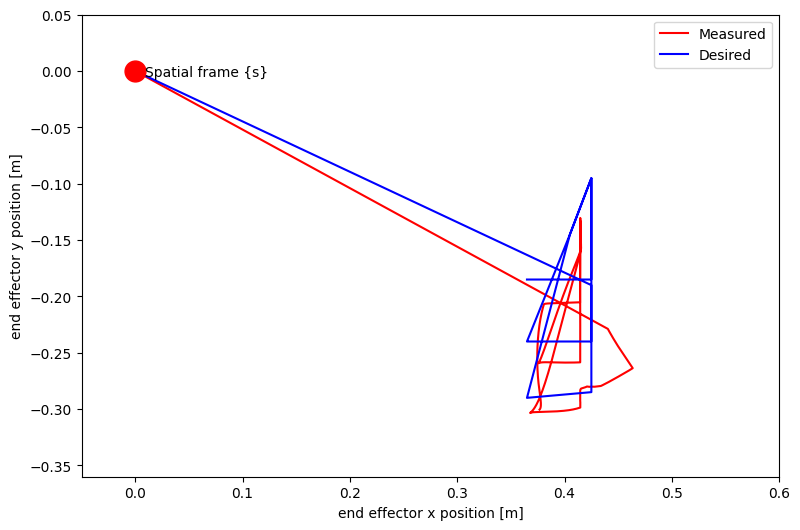

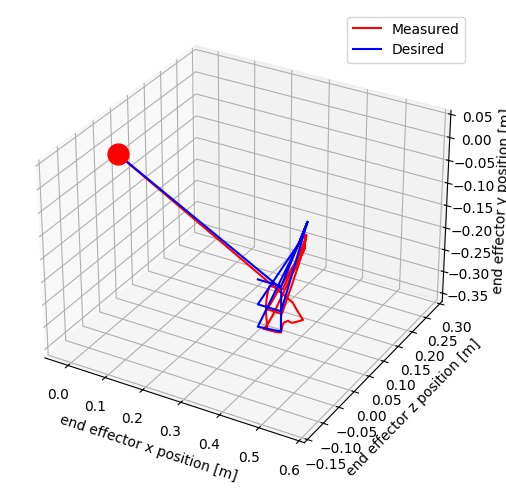

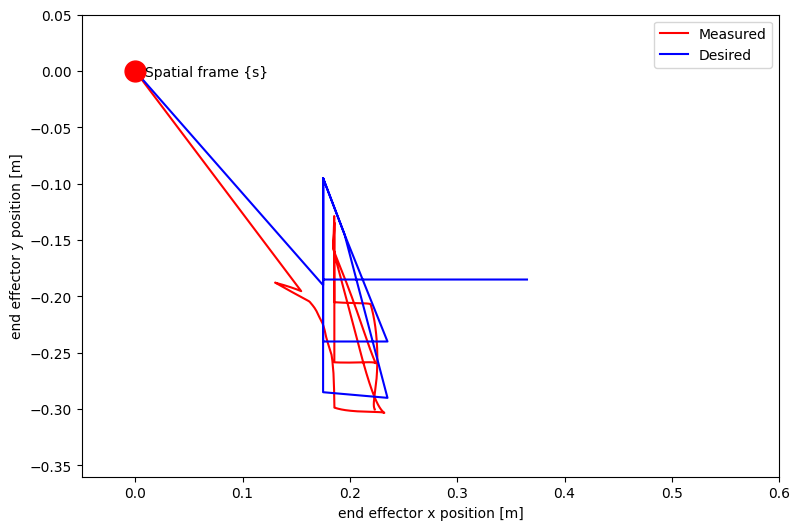

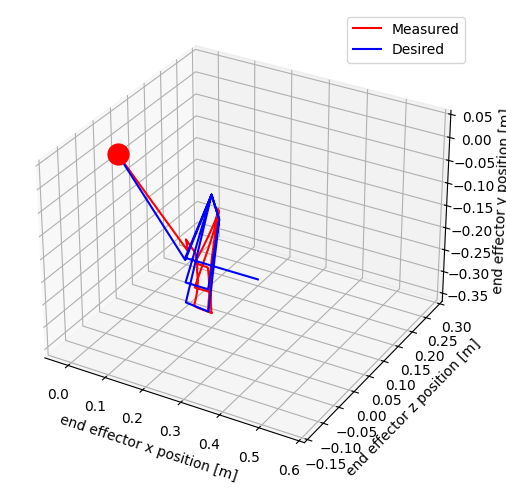

In [8]:
def plot_trajectory(measured_position, desired_position):
    """
    plots the position of the foot in 2D and the position of the spatial frame {s}
    we assume that the time varying x variable is in x_pos and that the y variable is in y_pos
    """
    fig = plt.figure(figsize=[9,6])
    ax = fig.add_subplot(111)
    plt.plot(measured_position[:,0],measured_position[:,1], 'r', label='Measured')
    plt.plot(desired_position[:,0],desired_position[:,1], 'b', label='Desired')
    plt.xlabel('end effector x position [m]')
    plt.ylabel('end effector y position [m]')
    plt.xlim([-0.05,0.6])
    plt.ylim([-0.36, 0.05])
    plt.plot([0],[0],'o',markersize=15,color='r')
    ax.annotate('Spatial frame {s}', xy=(-0.03,-0.005), xytext=(30,0), textcoords='offset points')
    plt.legend()
    
    fig = plt.figure(figsize=[9,6])
    ax = fig.add_subplot(111, projection='3d')
    ax.plot3D(measured_position[:,0],measured_position[:,2], measured_position[:,1], 'r', label='Measured')
    ax.plot3D(desired_position[:,0],desired_position[:,2], desired_position[:,1], 'b', label='Desired')
    ax.set_xlabel('end effector x position [m]')
    ax.set_zlabel('end effector y position [m]')
    ax.set_ylabel('end effector z position [m]')
    ax.set_xlim([-0.05,0.6])
    ax.set_zlim([-0.36, 0.05])
    ax.set_ylim([-0.15, 0.3])
    ax.plot3D([0],[0],[0],'o',markersize=15,color='r')
    ax.legend()
    
# you need to first create x_pos and y_pos variables!    
plot_trajectory(measured_finger_position_f1, desired_finger_position_f1)
plot_trajectory(measured_finger_position_f2, desired_finger_position_f2)

In [ ]:
def plot_trajectory(measured_position, desired_position):
    """
    plots the position of the foot in 2D and the position of the spatial frame {s}
    we assume that the time varying x variable is in x_pos and that the y variable is in y_pos
    """
    fig = plt.figure(figsize=[9,6])
    ax = fig.add_subplot(111)
    plt.plot(measured_position[:,0],measured_position[:,1], 'r', label='Measured')
    plt.plot(desired_position[:,0],desired_position[:,1], 'b', label='Desired')
    plt.xlabel('end effector x velocity [m]')
    plt.ylabel('end effector y velocity [m]')
    plt.xlim([-0.05,0.6])
    plt.ylim([-0.36, 0.05])
    plt.plot([0],[0],'o',markersize=15,color='r')
    ax.annotate('Spatial frame {s}', xy=(-0.03,-0.005), xytext=(30,0), textcoords='offset points')
    plt.legend()
    
    fig = plt.figure(figsize=[9,6])
    ax = fig.add_subplot(111, projection='3d')
    ax.plot3D(measured_position[:,0],measured_position[:,2], measured_position[:,1], 'r', label='Measured')
    ax.plot3D(desired_position[:,0],desired_position[:,2], desired_position[:,1], 'b', label='Desired')
    ax.set_xlabel('end effector x velocity [m]')
    ax.set_zlabel('end effector y velocity [m]')
    ax.set_ylabel('end effector z velocity [m]')
    ax.set_xlim([-0.05,0.6])
    ax.set_zlim([-0.36, 0.05])
    ax.set_ylim([-0.15, 0.3])
    ax.plot3D([0],[0],[0],'o',markersize=15,color='r')
    ax.legend()
    
# you need to first create x_pos and y_pos variables!    
plot_trajectory(measured_finger_velocity_f1, desired_finger_velocity_f1)
plot_trajectory(measured_finger_velocity_f2, desired_finger_velocity_f2)